**Importing Necessary Libraries**

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import googlenet


**Step 1. Create your own custom dataset featuring 3 custom categories of at least 100 images each.**

**Step 2. Split this data between 80% training and 20% test.**

 **Step 3. Preprocess the data as you see fit.**

   *  Considering Footwear dataset , it consists of 3 categories of footwear. Boot, Sandal and Shoe and each category has atleast 100 images.

Google Drive link for footwear dataset.

https://drive.google.com/drive/u/0/folders/1z1LTOLfDjT6FTdET9L2W96MevwphaKfj

In [2]:
#Defining data directory
data_directory = '/content/drive/MyDrive/Footwear/Footwear_Dataset'

#Defining preprocessing and augmentation transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  #Resizing images to 224x224 pixels
    transforms.RandomHorizontalFlip(),  #Randomly fliping images horizontally
    transforms.RandomRotation(10),       #Randomly rotating images by up to 10 degrees
    transforms.ColorJitter(0.2, 0.2, 0.2),  #Randomly change brightness, contrast, and saturation
    transforms.ToTensor(),           #Converting images to PyTorch tensors
    transforms.Normalize(            #Normalize pixel values
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


#Creating a custom dataset with preprocessing and augmentation
footwear_dataset = ImageFolder(data_directory, transform=preprocess)


In [3]:
#Splitting the dataset into training and test sets (80% training, 20% test)
train_size = int(0.8 * len(footwear_dataset))
test_size = len(footwear_dataset) - train_size
train_dataset, test_dataset = random_split(footwear_dataset, [train_size, test_size])

#Creating data loaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
class_names = footwear_dataset.classes
print(class_names)

['Boot', 'Sandal', 'Shoe']


##### **Visualizing the training data after preprocessing**

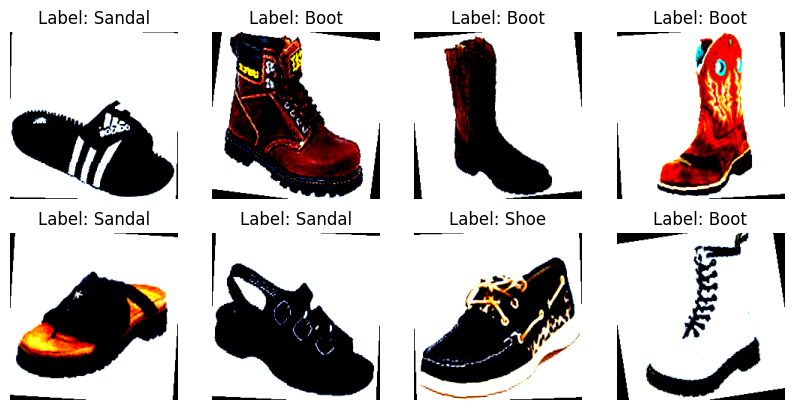

In [5]:
#Visualizing the training data after preprocessing
data_iteration = iter(train_loader)

#fetching first batch of testing data
images, labels = next(data_iteration)

#plotting first 8 images
plt.figure(figsize=(10, 10))
for i in range(8):
    image = images[i].permute(1, 2, 0).numpy()
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()

### **Step 4. Create a Convolutional Neural Network model to learn about your training set.**

In [6]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 3)  # 3 output classes

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

 #Initializing the customcnn model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN()

In [7]:
#defining loss function as cross entropy, optimizer as Adam and learning rate as 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
#Training the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    training_loss = 0.0
    training_accuracy = 0.0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            #computing training accuracy
            acc = accuracy(outputs, labels)
            training_accuracy += acc.item() * images.size(0)

            # Track training loss
            training_loss += loss.item() * images.size(0)

            # Print training statistics
        epoch_loss = training_loss / len(train_loader.dataset)
        epoch_acc = training_accuracy / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 10
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.1245, Accuracy: 0.4142
Epoch 2/10, Loss: 1.9880, Accuracy: 1.2030
Epoch 3/10, Loss: 2.6218, Accuracy: 2.0468
Epoch 4/10, Loss: 3.0651, Accuracy: 2.9359
Epoch 5/10, Loss: 3.3810, Accuracy: 3.8543
Epoch 6/10, Loss: 3.6867, Accuracy: 4.7685
Epoch 7/10, Loss: 3.9529, Accuracy: 5.6666
Epoch 8/10, Loss: 4.1882, Accuracy: 6.6230
Epoch 9/10, Loss: 4.3518, Accuracy: 7.6117
Epoch 10/10, Loss: 4.5264, Accuracy: 8.5939


In [9]:
#testing the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

num_epochs = 10
test_model(model, test_loader)

Test Accuracy: 0.9516


### **Step 5. Make predictions on the test data and compare them to the expected categories.**

In [10]:
#making predictions
def make_predictions(model, test_loader):
    model.eval()
    predictions = []
    ground_truth = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())
    return predictions, ground_truth

predictions, ground_truth = make_predictions(model, test_loader)

#comparing the predictions to ground truth
num_correct = sum(p == gt for p, gt in zip(predictions, ground_truth))
accuracy = num_correct / len(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

print("Sample Predictions vs. Ground Truth:")
for i in range(20):
    print(f"Prediction: {predictions[i]}, Ground Truth: {ground_truth[i]}")

Test Accuracy: 0.9355
Sample Predictions vs. Ground Truth:
Prediction: 1, Ground Truth: 1
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Prediction: 2, Ground Truth: 2
Prediction: 1, Ground Truth: 1
Prediction: 0, Ground Truth: 0
Prediction: 1, Ground Truth: 1
Prediction: 0, Ground Truth: 0
Prediction: 2, Ground Truth: 2
Prediction: 2, Ground Truth: 2
Prediction: 1, Ground Truth: 1
Prediction: 2, Ground Truth: 2
Prediction: 2, Ground Truth: 2
Prediction: 1, Ground Truth: 1
Prediction: 2, Ground Truth: 2
Prediction: 2, Ground Truth: 2
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Prediction: 1, Ground Truth: 1


* **Predicting the new unseen image**

The model predicts that the image belongs to class: Sandal


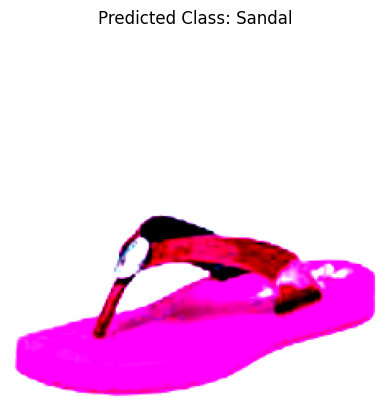

In [11]:
#defining the path to the unseen image
image_path = '/content/drive/MyDrive/Footwear/footwear_test_dataset/Sandal (5000).jpg'

#loading and preprocessing the unseen image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_image = Image.open(image_path)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  #adding a batch dimension

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)
model.eval()

#performing inference
with torch.no_grad():
    output = model(input_batch)

#getting the predicted class
_, predicted_class = output.max(1)

#mapping the predicted class to the class name in the footwear dataset directory
class_names = ['Boot', 'Sandal', 'Shoe']
predicted_class_name = class_names[predicted_class.item()]
print(f"The model predicts that the image belongs to class: {predicted_class_name}")

#visualizing the image
input_image = input_tensor.permute(1, 2, 0).numpy() #converting the input tensor back to a numpy array for visualization
plt.imshow(input_image)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')
plt.show()

### **Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.**

In [12]:
# Defining the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the pre-trained GoogleNet model
GoogleNet_model = googlenet(pretrained=True)

# Freezing the parameters of the pre-trained layers
for param in GoogleNet_model.parameters():
    param.requires_grad = False

# Modifying the classifier part of the GoogleNet model to add a linear layer
num_classes = 3  # Number of classes in the dataset
GoogleNet_model.fc = nn.Linear(GoogleNet_model.fc.in_features, num_classes)

# Defining loss function as cross entropy and optimizer as Adam with learning rate as 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(GoogleNet_model.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 101MB/s]


### **Step 7: Train the GoogleNet model and compare the accuracy with the first model.**

In [13]:
# Training the GoogleNet model
def train_model(GoogleNet_model, train_loader, criterion, optimizer, num_epochs=10):
    GoogleNet_model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = GoogleNet_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

train_model(GoogleNet_model, train_loader, criterion, optimizer)


# Testing the GoogleNet model
def test_model(GoogleNet_model, test_loader):
    GoogleNet_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = GoogleNet_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

test_model(GoogleNet_model, test_loader)

Epoch 1/10, Loss: 0.9519
Epoch 2/10, Loss: 0.4385
Epoch 3/10, Loss: 0.2704
Epoch 4/10, Loss: 0.2108
Epoch 5/10, Loss: 0.1836
Epoch 6/10, Loss: 0.1646
Epoch 7/10, Loss: 0.2004
Epoch 8/10, Loss: 0.2024
Epoch 9/10, Loss: 0.1480
Epoch 10/10, Loss: 0.1759
Test Accuracy: 0.9839


Test Accuracy: 0.9516
Sample Predictions vs. Ground Truth:
Prediction: 1, Ground Truth: 1
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Prediction: 2, Ground Truth: 2
Prediction: 1, Ground Truth: 1
Prediction: 0, Ground Truth: 0
Prediction: 1, Ground Truth: 1
Prediction: 0, Ground Truth: 0
Prediction: 2, Ground Truth: 2
Prediction: 2, Ground Truth: 2
Prediction: 1, Ground Truth: 1
Prediction: 2, Ground Truth: 2
Prediction: 1, Ground Truth: 2
Prediction: 1, Ground Truth: 1
Prediction: 2, Ground Truth: 2
Prediction: 2, Ground Truth: 2
Prediction: 0, Ground Truth: 0
Prediction: 0, Ground Truth: 0
Prediction: 1, Ground Truth: 1


The GoogleNet model predicts that the image belongs to class: Boot


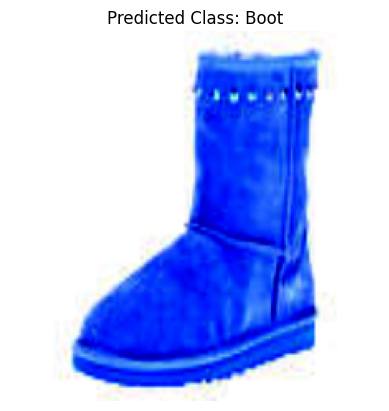

In [14]:
# Making predictions on GoogleNet model
def make_predictions(GoogleNet_model, test_loader):
    GoogleNet_model.eval()
    predictions = []
    ground_truth = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = GoogleNet_model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())
    return predictions, ground_truth

predictions, ground_truth = make_predictions(GoogleNet_model, test_loader)

# Comparing the predictions to ground truth
num_correct = sum(p == gt for p, gt in zip(predictions, ground_truth))
accuracy = num_correct / len(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

print("Sample Predictions vs. Ground Truth:")
for i in range(min(20, len(predictions))):
    print(f"Prediction: {predictions[i]}, Ground Truth: {ground_truth[i]}")

# Predicting a new unseen image
def predict_image(GoogleNet_model, image_tensor):
    GoogleNet_model.eval()
    with torch.no_grad():
        outputs = GoogleNet_model(image_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Loading and preprocessing a new unseen image
image_path = '/content/drive/MyDrive/Footwear/footwear_test_dataset/boot (4961).jpg'
input_image = Image.open(image_path)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
input_tensor = transform_test(input_image).unsqueeze(0)
input_tensor = input_tensor.to(device)

predicted_class = predict_image(GoogleNet_model, input_tensor)

# Mapping the predicted class to class name
class_names = ['Boot', 'Sandal', 'Shoe']
predicted_class_name = class_names[predicted_class]
print(f"The GoogleNet model predicts that the image belongs to class: {predicted_class_name}")

input_image = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
plt.imshow(input_image)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')
plt.show()

The custom CNN model achieved a test accuracy of 0.9355, indicating that it is correctly classifying approx 93.55% of the test dataset.
And the the GoogleNet model obatined an test accuracy of 0.9516, indicating a correct classification rate of approximately 96.16%.

Both the models have achived high accuracy for the provided dataset.The GoogleNet model did slightly better than the CNN model in terms of accuracy.But both the models have predicted the new unseen image correctly.